In [68]:
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import glob
import os
import matplotlib.pyplot as plt

In [77]:
def backtest_with_benchmark(weights: pd.DataFrame,
                            returns_df: pd.DataFrame,
                            weights_benchmark: pd.DataFrame,
                            cost_rate: float = 0.001,
                            rf: float = 0.0):
    """
    Backtest a strategy against a benchmark, including transaction costs.
    
    Parameters
    ----------
    weights : pd.DataFrame
        Daily target weights for the strategy.
    returns_df : pd.DataFrame
        Daily returns DataFrame.
    weights_benchmark : pd.DataFrame
        Daily target weights for the benchmark.
    cost_rate : float
        Proportional transaction cost per unit turnover.
    rf : float
        Annual risk-free rate for Sharpe ratio calculation.
        
    Returns
    -------
    results : dict
        Contains:
            - net_returns_strategy, cumulative_strategy, metrics_strategy
            - net_returns_benchmark, cumulative_benchmark, metrics_benchmark
    """
    # Strategy raw returns
    strat_raw = (weights * returns_df).sum(axis=1)
    # Strategy turnover & costs
    strat_turn = weights.diff().abs().sum(axis=1)
    strat_turn.iloc[0] = weights.iloc[0].abs().sum()
    strat_costs = strat_turn * cost_rate
    strat_net = strat_raw - strat_costs
    strat_cum = (1 + strat_net).cumprod()
    
    # Benchmark raw returns
    bench_raw = (weights_benchmark * returns_df).sum(axis=1)
    # Benchmark turnover & costs
    bench_turn = weights_benchmark.diff().abs().sum(axis=1)
    bench_turn.iloc[0] = weights_benchmark.iloc[0].abs().sum()
    bench_costs = bench_turn * cost_rate
    bench_net = bench_raw - bench_costs
    bench_cum = (1 + bench_net).cumprod()
    
    def compute_metrics(net_ret, cum_ret):
        n = net_ret.shape[0]
        total = cum_ret.iloc[-1]
        ann_ret = total ** (252 / n) - 1
        ann_vol = net_ret.std() * np.sqrt(252)
        sharpe = (ann_ret - rf) / ann_vol if ann_vol != 0 else np.nan
        dd = cum_ret / cum_ret.cummax() - 1
        max_dd = dd.min()
        return {
            'annual_return': ann_ret,
            'annual_volatility': ann_vol,
            'sharpe_ratio': sharpe,
            'max_drawdown': max_dd
        }
    
    metrics_strat = compute_metrics(strat_net, strat_cum)
    metrics_bench = compute_metrics(bench_net, bench_cum)
    
    # Plot both cumulative returns on same chart
    plt.figure()
    strat_cum.plot(label='Strategy')
    bench_cum.plot(label='Benchmark')
    plt.title('Cumulative Returns: Strategy vs Benchmark')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return {
        'net_returns_strategy': strat_net,
        'cumulative_strategy': strat_cum,
        'metrics_strategy': metrics_strat,
        'net_returns_benchmark': bench_net,
        'cumulative_benchmark': bench_cum,
        'metrics_benchmark': metrics_bench
    }

# 调用示例：
# results = backtest_with_benchmark(weights, returns_df, weights_benchmark, cost_rate=0.001)
# print("Strategy Metrics:", results['metrics_strategy'])
# print("Benchmark Metrics:", results['metrics_benchmark'])


In [59]:
# Returns
csv_files = glob.glob("../data/raw/*.csv")
dfs = {}
for file in csv_files:
    symbol = os.path.splitext(os.path.basename(file))[0]
    if symbol in ['BF.B','BRK.B','CTLT']:
        continue
    df = pd.read_csv(file, index_col=0 )

    df = df[~df.index.duplicated(keep='first')]
    num_cols = ["open", "high", "low", "close", "vol", "pct_change", "vwap"]
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    df['return'] = df['pct_change'] / 100.0
    dfs[symbol] = df

In [60]:
# expected returns
csv_files = glob.glob("../data/predictions/expected_returns/*.csv")
dfs_return = []
for file in csv_files:
    df = pd.read_csv(file, index_col=0)
    df = df[~df.index.duplicated(keep='first')]
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    dfs_return.append(df)

In [61]:
# volatilities
csv_files = glob.glob("../data/predictions/volatilities/*.csv")
dfs_volatility = []
for file in csv_files:
    df = pd.read_csv(file, index_col=0)
    df = df[~df.index.duplicated(keep='first')]
    df.sort_index(inplace=True)
    df = df.ffill().bfill()
    dfs_volatility.append(df)

In [62]:
returns_df = pd.DataFrame({sym: df['return'] for sym, df in dfs.items()})
expected_returns = pd.concat(dfs_return, axis=0)
expected_volatility = pd.concat(dfs_volatility, axis=0)


In [105]:
score_df = expected_returns / expected_volatility
score_df = score_df.rolling(window=40).mean()

In [106]:
score = score_df.iloc[0]
score = score[score > 0].sort_values(ascending=True)

In [107]:
score

Series([], Name: 2015-02-02, dtype: float64)

In [108]:
position = pd.DataFrame(index=score_df.index, columns=returns_df.columns)
benchmark_position = position.copy()
benchmark_position.loc[:, :] = 1 / len(benchmark_position.columns)
for i in trange(len(score_df)):
    score = score_df.iloc[i]
    score = score[score > 0].sort_values(ascending=True)
    weight = np.arange(1, len(score)+1) / np.sum(np.arange(1, len(score)+1))
    position.iloc[i, :] = 0.0
    if len(weight) > 0:
        position.loc[score_df.index[i], score.index] = weight

  0%|          | 0/2493 [00:00<?, ?it/s]

In [109]:
returns_df = returns_df.loc[position.index, position.columns]

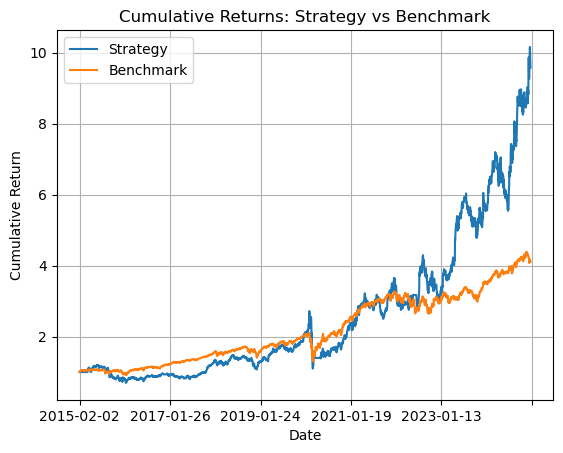

{'net_returns_strategy': 2015-02-02         0.0
2015-02-03         0.0
2015-02-04         0.0
2015-02-05         0.0
2015-02-06         0.0
                ...   
2024-12-24    0.021011
2024-12-26    0.005187
2024-12-27   -0.018816
2024-12-30    -0.01718
2024-12-31   -0.022142
Length: 2493, dtype: object, 'cumulative_strategy': 2015-02-02          1.0
2015-02-03          1.0
2015-02-04          1.0
2015-02-05          1.0
2015-02-06          1.0
                ...    
2024-12-24    10.110656
2024-12-26    10.163103
2024-12-27     9.971873
2024-12-30     9.800553
2024-12-31     9.583553
Length: 2493, dtype: object, 'metrics_strategy': {'annual_return': 0.2566538966602756, 'annual_volatility': 0.3522882897682743, 'sharpe_ratio': 0.7285337154666582, 'max_drawdown': -0.5963620246070207}, 'net_returns_benchmark': 2015-02-02    0.007683
2015-02-03    0.014253
2015-02-04   -0.003466
2015-02-05    0.010644
2015-02-06   -0.004401
                ...   
2024-12-24    0.007834
2024-12-26    0.00

In [110]:
results = backtest_with_benchmark(position, returns_df, benchmark_position, cost_rate=0.002)
print(results)

In [111]:
print("Strategy Metrics:", results['metrics_strategy'])
print("Benchmark Metrics:", results['metrics_benchmark'])

Strategy Metrics: {'annual_return': 0.2566538966602756, 'annual_volatility': 0.3522882897682743, 'sharpe_ratio': 0.7285337154666582, 'max_drawdown': -0.5963620246070207}
Benchmark Metrics: {'annual_return': 0.15362307413642506, 'annual_volatility': 0.18219108296444772, 'sharpe_ratio': 0.843197546426587, 'max_drawdown': -0.38151818002056637}
